# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2)

### Question 1 

_Describe the techniques used to preprocess the data._


**Answer:** 

After reading the [YanLeCunn paper](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf), we can follow the way he did for preprocessing the data. The images are down-sampled to 32x32 and loaded the pickle data set which already filtered as input shape 32x32x3. As we see above the X_train, X_val and X_test are divided by 255. These idea have taken from the normalizing the features for training, validation and test data. We considered to normalize to the max for preprocessing the normalization. This brings us to the YUV Space where the Y channel is preprocessed with global and local contrast. We left U and V unchanged.

I do preprocess the data by converting them to rgb. I was wondering even with human eyes how we can recognize the image in rgb. Leveraging from hough transform P1, I had an idea to convert grayscale, flat it to 1024 pixels. After that, we can normalize the data using the minmax formula. I did one hot encoded the label and it translates the change for each sign label index number to binary format. One hot encoded labels are all array of zeros expect starting index of the sign label. The label maps to the signnames.csv file for all 43 sign label indexes.

In [22]:
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math
import matplotlib.image as mpimg
import cv2
from IPython.display import Image
import pickle
from PIL import Image
import matplotlib.image as mpimg
import collections
import hashlib
import os
from urllib.request import urlretrieve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
import time
import datetime
from datetime import timedelta
%matplotlib inline

In [23]:
image0 = mpimg.imread('random/Yield.jpg')
image1 = mpimg.imread('random/General_caution.jpg')
image2 = mpimg.imread('random/Stop2.jpg')
image3 = mpimg.imread('random/Stop3.jpg')
image4 = mpimg.imread('random/Double_curve.jpg')
image5 = mpimg.imread('random/No_entry.jpg')
image6 = mpimg.imread('random/Speed_limit_(50).jpg')
image7 = mpimg.imread('random/No_passing.jpg')
image8 = mpimg.imread('random/Wild_animals_crossing.jpg')

In [24]:
print(image1.shape)
my_test_X = np.array([image0, image1, image2, image3, image4, image5, image6, image7, image8])
my_test_y = np.array([ 13, 18, 14, 14, 21, 17, 2, 9, 31])
my_test_y2 = my_test_y 


(32, 32, 3)


In [27]:
# Load pickled data
# TODO: fill this in based on where you saved the training and testing data

training_file = "data/train.p"
testing_file = "data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)

with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']
y_train2 =y_train
y_test2 = y_test

In [28]:
def rgb_to_gray(array):
    fs = []
    for i in range(0,array.shape[0]):
        image = array[i]
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        fs.append(gray_image)    
    return np.array(fs)


X_train = rgb_to_gray(X_train)
X_test = rgb_to_gray(X_test)
my_test_X =rbg_to_gray(my_test_X)
print (X_train.shape)

X_train2=X_train
X_test2=X_test
my_test_X2=my_test_X

(39209, 32, 32)


In [29]:
img_size = 32
img_size_flat = img_size * img_size
img_shape = (img_size, img_size)
num_channels = 1
num_classes = 43

In [30]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### Visualization of 9 Random Training Images.

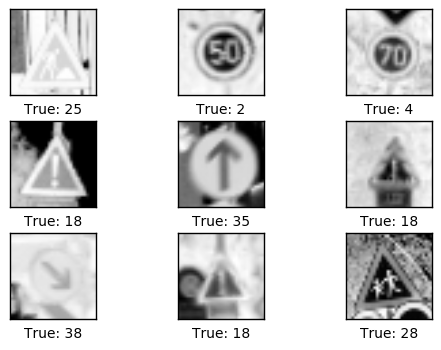

In [31]:
idx = np.random.choice(X_train.shape[0], size=9, replace=False)
images = X_train[idx,:]
# Get the true classes for those images.
cls_true = y_train[idx]
# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)

### Visualization of 9 Random Test Images.

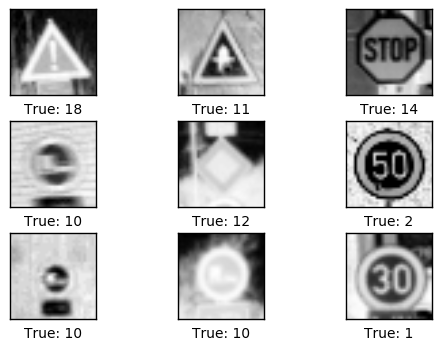

In [32]:
#Random selection of 9 images from X_train.
idx = np.random.choice(X_test.shape[0], size=9, replace=False)
images = X_test[idx,:]
# Get the true classes for those images.
cls_true = y_test[idx]
# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)

### Visualization of my_test Images.

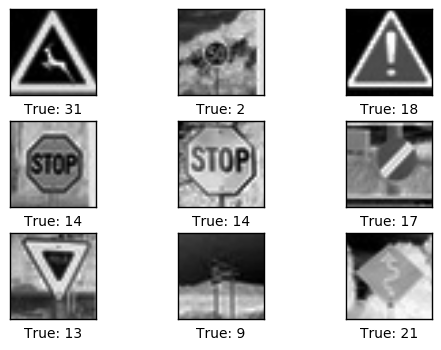

In [33]:
#Random selection of 9 images from my_test_X.
idx = np.random.choice(my_test_X.shape[0], size=9, replace=False)
images = my_test_X[idx,:]
# Get the true classes for those images.
cls_true = my_test_y[idx]
# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)

### Data Counts

In [34]:
### To start off let's do a basic data summary.

# TODO: number of training examples
n_train = X_train.shape[0]

# TODO: number of testing examples
n_test = X_test.shape[0]

# TODO: number of testing examples
n_my_test = my_test_X.shape[0]

# TODO: what's the shape of an image?
image_shape = X_train.shape[1:3]

# TODO: how many classes are in the dataset
n_classes = len(set(train['labels']))
# TODO: how many classes are in the dataset
n_classes2 = len(set(test['labels']))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Number of my_test examples =", n_my_test)
print("Image data shape =", image_shape, 32*32)
print("Number of classes =", n_classes, )


Number of training examples = 39209
Number of testing examples = 12630
Number of my_test examples = 9
Image data shape = (32, 32) 1024
Number of classes = 43


### Visualization of Count of Training Samples by Sign Type Index

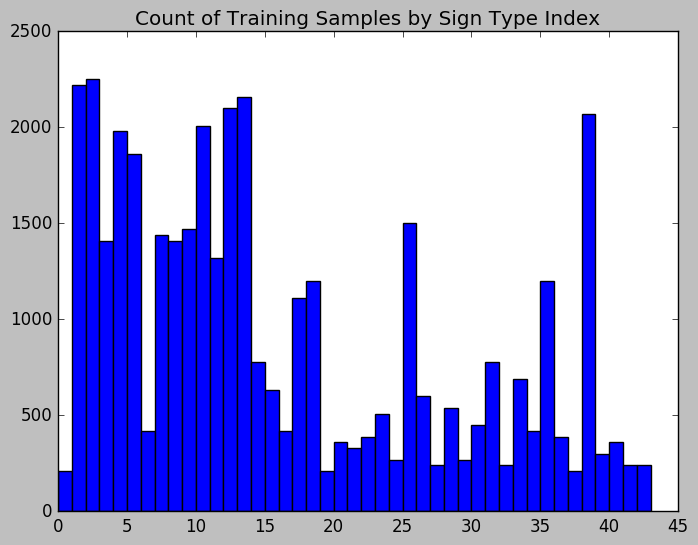

In [75]:
train_label_count = collections.Counter(train['labels'])
labels, values = zip(*train_label_count.items())
indexes = np.arange(len(labels))
width = 1
plt.title("Count of Training Samples by Sign Type Index")
plt.bar(indexes, values, width)
plt.show()


### Visualization of Count of Test Samples by Sign Type Index

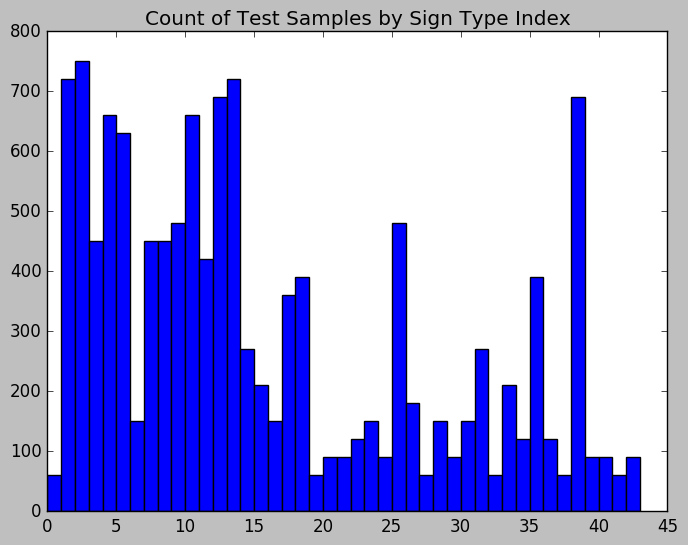

In [76]:
test_label_count = collections.Counter(test['labels'])

#print (test_label_count, type(test_label_count))
labels, values = zip(*test_label_count.items())
#print(labels, values)
indexes = np.arange(len(labels))
width = 1
plt.title("Count of Test Samples by Sign Type Index")
plt.bar(indexes, values, width)
plt.show()

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [37]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.

In [39]:
def flatten_gray(array):
    fs = []
    for i in range(0,array.shape[0]):
        image = array[i]
        f = np.array(image, dtype=np.float32).flatten()
        fs.append(f)
    return np.array(fs) 
    
X_train = flatten_gray(X_train)
X_test = flatten_gray(X_test)
my_test_X =flatten_gray(my_test_X)

In [40]:
def normalize_greyscale(image_data):
    alpha= 0.1
    beta= 0.9
    min = 0
    max =255
    #value = 0.1 + ((image_data- min)*(b-a))/(max-min)
    greyscale_min = 0
    greyscale_max = 255
    return alpha + ( ( (image_data - greyscale_min)*(beta - alpha) )/( greyscale_max - greyscale_min ) )

X_train = normalize_greyscale(X_train)
X_test = normalize_greyscale(X_test)
my_test_X = normalize_greyscale(my_test_X)

In [41]:
# Turn labels into numbers and apply One-Hot Encoding
encoder = LabelBinarizer()
encoder.fit(y_train)
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)
my_test_y = encoder.transform(my_test_y)

# Change to float32, so it can be multiplied against the features in TensorFlow, which are float32
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)
my_test_y = my_test_y.astype(np.float32)

### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:**  
As we noticed from the dataset exploration, the features are 32x32x3. Two options are advertised in this situation. I have decided to derive the model use convolutional network method. In addition for the training, validation and testing data, we try to keep the training and testing from the provided dataset.

Let's plan how we are going to write the functions for ConvNet and pass the maxpool configuration.

The conv2d contains the convnet 2 dimensional plus the maxpool as well 2 dimensional.

The training set was randomly split into a training and validation groups. The percent of the split was tested at a validation set of  10%, 15%, 25% and 33%. 15% was found to have the best test accuacy so it was the percentage chosen.

In [42]:
# Get randomized datasets for training and validation

X_train, X_valid, y_train, y_valid = train_test_split(
    X_train,
    y_train,
    test_size=0.15,
    random_state=0)
X_train, y_train = shuffle(X_train, y_train)
X_test, y_test = shuffle(X_test, y_test)

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:** 

I do Convolutional Neural Network approach. 

Let's set our learning parameters:
We will set our parameters with 10 training epoch, batch size of 64. As we know the training examples are 39209 and there are 43 classes as number of traffic signs with image shape 32x32

In this problem, our bias set in our definition conv2d. In this definition, we want to pass the input and filter with an assumption the strides would be 1,1 matrices. The kernel will be the weigths in this case. It will output random values from a normal distribution with zero mean and 0.1 standard deviation. 

I'm quoting the idea from CS231N from Stanford about Strides. ["Evaluating the original ConvNet (with FC layers) independently across 224x224 crops of the 384x384 image in strides of 32 pixels gives an identical result to forwarding the converted ConvNet one time."](http://cs231n.github.io/convolutional-networks/) 

I do care about the strides. By it means the layer I'm using filter of size 1x1 and slides it over the training image. Each time it stops (dictated by the stride-imagine it like bounding label), the filter performs a function involving the pixels that it lies on. 

A simple stride of 1 and padding of 0 was used. Pooling used was max pooling over a 2 by 2 block. The architecture has two convolutional layer. 

The first will run 32 features for each of the 5 by 5 patch then max pooling was applied. (32x32 ->16x16)

The second convolutional layer computed 64 features for each 5 by 5 patch and again max pooling. (16x16-> 8x8)

The next step is do full connected layer with 1024 features and set the dropout to avoid overfitting.

ReLu nodes are used with nn, of each layer, initialize to a small amount of noise and bias, of each, initialized to a slight positive value of 0.01. 

In [43]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

x = tf.placeholder(tf.float32, shape=[None, 1024])
y_ = tf.placeholder(tf.float32, shape=[None, 43])
W = tf.Variable(tf.zeros([1024,43]))
b = tf.Variable(tf.zeros([43]))

W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])
x_image = tf.reshape(x, [-1,32,32,1])

h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

W_fc1 = weight_variable([8 * 8 * 64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 8*8*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

W_fc2 = weight_variable([1024, 43])
b_fc2 = bias_variable([43])

y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

sm=tf.nn.softmax(y_conv)

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**  I did Gradient Optimizer. The result wasn't good. I've found out Adam works well in this situation. I ended up batch size of 64, epochs of 10.

The method I use to find best learning rate and batch size is grid search  I tested first tested learning rates of (0, 1e-5, 1e-4, 1e-3) and batch sizes of (5, 10, 24, 32, 64). 

Initially used an epoch of 3 to get a general idea of the convnet output. Then, I tried a few of the best combinations of learning rate and batch size at an epoch of 10. I ended up using a learning rate of 0 and a batch size of 64. 

In [58]:
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y_conv, y_))
train_step = tf.train.AdamOptimizer().minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
sess.run(tf.initialize_all_variables())

In [60]:
# Initializing the variables
init = tf.initialize_all_variables()

# Launch the graph
sess = tf.Session()
sess.run(init)
batch_size=64
total_samples = X_train.shape[0]
epochs = 10

#Loops (at batch size) to get through data once.
loops = int(total_samples / batch_size) 

print("Start ",datetime.datetime.now().time())

for i in range(epochs):
    #for j in range(800):
    for j in range(loops):
      batch_start = j*batch_size
      batch_features = X_train[batch_start:(batch_start + batch_size)]
      batch_labels = y_train[batch_start:(batch_start + batch_size)] 

      if j%100 == 0:
        train_accuracy = accuracy.eval(feed_dict={
            x:batch_features, y_: batch_labels, keep_prob: 1.0})
            #x: X_train[0:50], y_: y_train[0:50], keep_prob: 1.0})  
        print("step %d, training accuracy %g, batch start %d"%(j, train_accuracy, batch_start))

      train_step.run(feed_dict={x: batch_features, y_: batch_labels, keep_prob: 0.5})

    print("valid accuracy %g"%accuracy.eval(feed_dict={
        x: X_valid, y_: y_valid, keep_prob: 1.0}))

print("test accuracy %g"%accuracy.eval(feed_dict={    
    x: X_test, y_: y_test, keep_prob: 1.0}))    

print ("Finished ", datetime.datetime.now().time())


Start  22:00:11.335710
step 0, training accuracy 1, batch start 0
step 100, training accuracy 0.984375, batch start 6400
step 200, training accuracy 1, batch start 12800
step 300, training accuracy 1, batch start 19200
step 400, training accuracy 1, batch start 25600
step 500, training accuracy 1, batch start 32000
valid accuracy 0.986569
step 0, training accuracy 1, batch start 0
step 100, training accuracy 1, batch start 6400
step 200, training accuracy 1, batch start 12800
step 300, training accuracy 1, batch start 19200
step 400, training accuracy 1, batch start 25600
step 500, training accuracy 1, batch start 32000
valid accuracy 0.988609
step 0, training accuracy 1, batch start 0
step 100, training accuracy 1, batch start 6400
step 200, training accuracy 1, batch start 12800
step 300, training accuracy 1, batch start 19200
step 400, training accuracy 1, batch start 25600
step 500, training accuracy 1, batch start 32000
valid accuracy 0.987759
step 0, training accuracy 1, batch st

### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:** 

Iteration, patience and a lot of research for few models. I did feed forward, deep convnet and looked into the MNIST code from [Hvass-lab](https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/02_Convolutional_Neural_Network.ipynb) to get the general idea how to get my model. I have found out rgb to grayscale is very useful method dealing with different types of traffic signs. At the beginning, I couldn't recognize the traffic sign based on the matplotlib output. Leveraging from P1 I have figured it's the best way to grayscale the image to recognize signs better.

For the architecture the DNN I created first to play around with the pooling. Then later on, I was trying to figured out the output of pooling. Trials and failures, I tried to figure out how the dimension works and how it relates to the pooling reduced size of image. For an example, from 32x32 to 16x16 and 8x8.

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

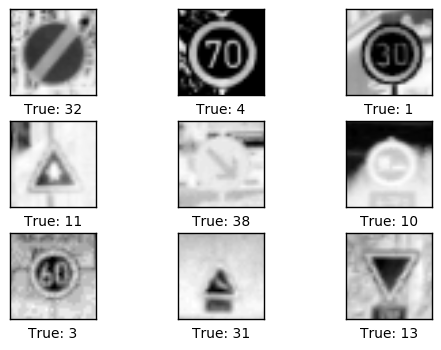

Train set sample images


In [61]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

# Images were loaded above, before preprocessing.

#Random selection of 9 images from X_train.
idx = np.random.choice(X_train2.shape[0], size=9, replace=False)
images = X_train2[idx,:]
# Get the true classes for those images.
cls_true = y_train2[idx]
# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)

print ("Train set sample images")

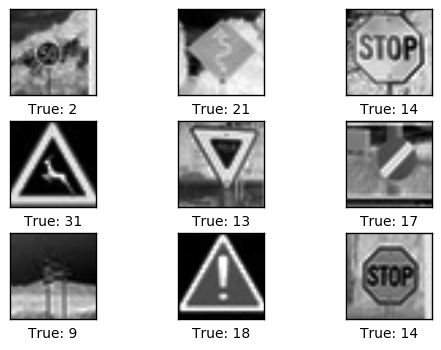

My test set sample images


In [62]:
#Random selection of 9 images from X_train.
idx = np.random.choice(my_test_X2.shape[0], size=9, replace=False)
images = my_test_X2[idx,:]
# Get the true classes for those images.
cls_true = my_test_y2[idx]
# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)

print ("My test set sample images")

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:** 

It only recognize about 40% of the test images. It gets less acurate because of the cropping. 

In [63]:
predictions=[]
for i in range(0,9):
    predict = np.argmax(sm.eval(feed_dict={x:my_test_X , y_: my_test_y, keep_prob: 1.0})[i])
    predictions.append(predict)
print (predictions)

[12, 18, 14, 14, 12, 6, 14, 25, 31]


In [67]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

print("Final test accuracy %g\n"%accuracy.eval(feed_dict={
    x: my_test_X, y_: my_test_y, keep_prob: 1.0}))

for i in range(0,len(my_test_y)):
    flag =""
    predict = predictions[i]    
    true = np.argmax(my_test_y[i])
    if (predict == true):
        flag = True
    print ("My test prediction for image %d is: %d. \nThe true value is: %d  %s\n"%(i,predict,true,flag))


Final test accuracy 0.444444

My test prediction for image 0 is: 12. 
The true value is: 13  

My test prediction for image 1 is: 18. 
The true value is: 18  True

My test prediction for image 2 is: 14. 
The true value is: 14  True

My test prediction for image 3 is: 14. 
The true value is: 14  True

My test prediction for image 4 is: 12. 
The true value is: 21  

My test prediction for image 5 is: 6. 
The true value is: 17  

My test prediction for image 6 is: 14. 
The true value is: 2  

My test prediction for image 7 is: 25. 
The true value is: 9  

My test prediction for image 8 is: 31. 
The true value is: 31  True



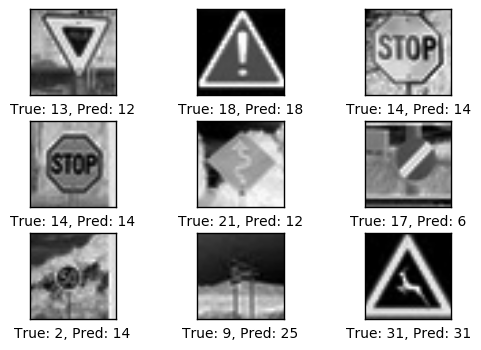

In [68]:
idx = list(range(0, 9))
images = my_test_X[idx,:]

# Get the true classes for those images.
cls_true = my_test_y2[idx]
# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true, cls_pred=predictions )

### Question 7

_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the dataset?_


**Answer:** 

No it's not. The reason I mentioned above because of the cropping. My test set should have 55% accuracy and test set should be around 92% accuracy with with 10 epochs. First it calculates 64 the next calculates 1024. Varying these numbers may improve accuracy. Another option, create the third layers and FC them together.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:** 

The first image below shows a incorrect prediction for signs name index 13. The second image below show a correct value for index 18. A few other indexes had low value none above 0.5. Most of the others had a wrong index at a high value.

In [69]:
smp = sm.eval(feed_dict={x:my_test_X , y_: my_test_y, keep_prob: 1.0})[8]
smpL = list(smp)
indexes = list(range(43))

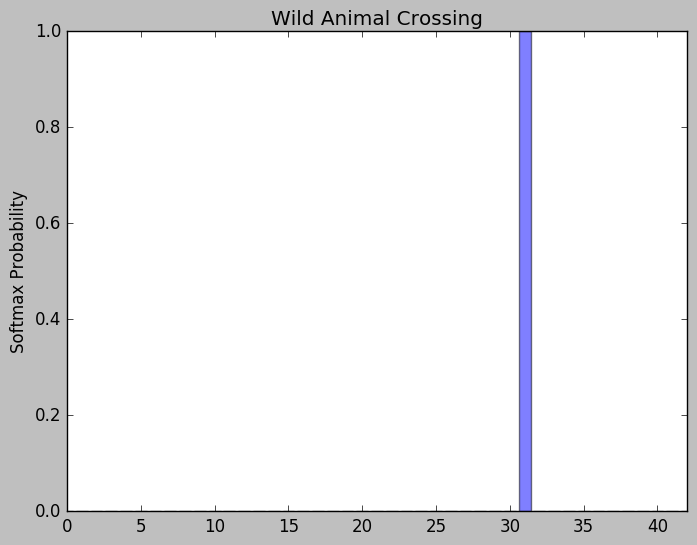

In [72]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

import matplotlib.pyplot as plt; plt.rcdefaults()

plt.bar(indexes, smpL, align='center', alpha=0.5)
plt.xlim(0,42)
plt.ylabel('Softmax Probability')
plt.title('Wild Animal Crossing')
 
plt.show()


Above is a 'Wild animals crossing' sign with a sign name index of 31 and it is clearly correct.

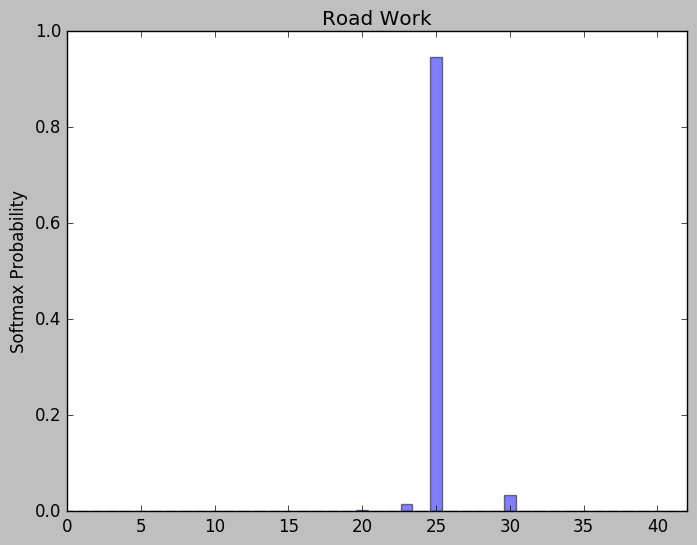

In [74]:
smp2 = sm.eval(feed_dict={x:my_test_X , y_: my_test_y, keep_prob: 1.0})[7]
smpL2 = list(smp2)
plt.bar(indexes, smpL2, align='center', alpha=0.5)
plt.xlim(0,42)
plt.ylabel('Softmax Probability')
plt.title('Road Work')
 
plt.show()

The above is a 'Road Work' that has a index of 25. The index 25 is the one with 
the highest probability and appears to have noise in index 30 and 24.

### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:** N/A